In [22]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import numpy as np
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from matplotlib import colormaps

In [2]:
def load_csv(path):
    df = pd.read_csv(path, dtype=str, low_memory=False)
    
    ngrams = df["ngram"].iloc[1:].values  
    samples = []
    data = []

    for col in df.columns[1:]:
        virus_type = col.split(".")[0]  
        protein_type = df[col].iloc[0]  
        values = pd.to_numeric(df[col].iloc[1:], errors="coerce").fillna(0).values  

        samples.append({"virus_type": virus_type, "protein_type": protein_type})
        data.append(values)

    df_final = pd.DataFrame(data, columns=ngrams)
    df_final = pd.concat([pd.DataFrame(samples), df_final], axis=1)
    return df_final

# KMeans

In [3]:
def kmeans_clustering(datasets, label_column="virus_type", cluster_range=range(2, 11)):
    """
    Runs KMeans clustering on amino acid n-gram datasets.
    Podržava bojenje po 'virus_type' ili 'protein_type'.
    """

    # Prettier titles for legend
    pretty_titles = {
        "virus_type": "Virus",
        "protein_type": "Protein"
    }

    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} 
               for ngram in datasets}

    fig, axes = plt.subplots(len(datasets), 4, figsize=(22, 5 * len(datasets)))
    if len(datasets) == 1:
        axes = [axes]

    for i, (ngram, df) in enumerate(datasets.items()):
        # Ekstra label-e
        labels = df[label_column].astype(str).values

        # Uzmi numeričke kolone
        features_df = df.select_dtypes(include=[np.number])
        features = features_df.values

        # Skaliranje
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # Evaluacija metrika
        for k in cluster_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(features_scaled)
            cluster_labels = kmeans.labels_

            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(features_scaled, cluster_labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(features_scaled, cluster_labels))
            results[ngram]["davies"].append(davies_bouldin_score(features_scaled, cluster_labels))

        # --- Plot metrics ---
        metrics = ["silhouette", "calinski", "davies"]
        for j, metric in enumerate(metrics):
            ax = axes[i][j]
            ax.plot(results[ngram]["clusters"], results[ngram][metric], marker="o")
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Broj klastera")
            ax.set_ylabel(metric.capitalize())

        # --- Scatter plot za najbolji broj klastera ---
        best_k = results[ngram]["clusters"][np.argmax(results[ngram]["silhouette"])]
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto").fit(features_scaled)
        cluster_labels = kmeans.labels_

        ax_scatter = axes[i][3]
        ax_scatter.set_title(f"{ngram} - KMeans (k={best_k}) colored by {pretty_titles.get(label_column, label_column)}")

        # Uzmemo samo prve 2 dimenzije PCA ili originalne (da se može crtati)
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(features_scaled)

        scatter = ax_scatter.scatter(reduced[:, 0], reduced[:, 1], 
                                     c=[hash(l) % 10 for l in labels], cmap="tab10", s=40)

        # Legenda sa virusima/proteinima
        unique_labels = sorted(set(labels))
        ncols = 1
        if len(unique_labels) > 10:
            ncols = 2
        if len(unique_labels) > 20:
            ncols = 3

        ax_scatter.legend(handles=scatter.legend_elements()[0],
                          labels=unique_labels,
                          title=pretty_titles.get(label_column, label_column),
                          bbox_to_anchor=(1.05, 1), loc="upper left",
                          borderaxespad=0.,
                          ncol=ncols)

    plt.tight_layout()
    plt.show()

    return results

In [4]:
df3 = load_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = load_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = load_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

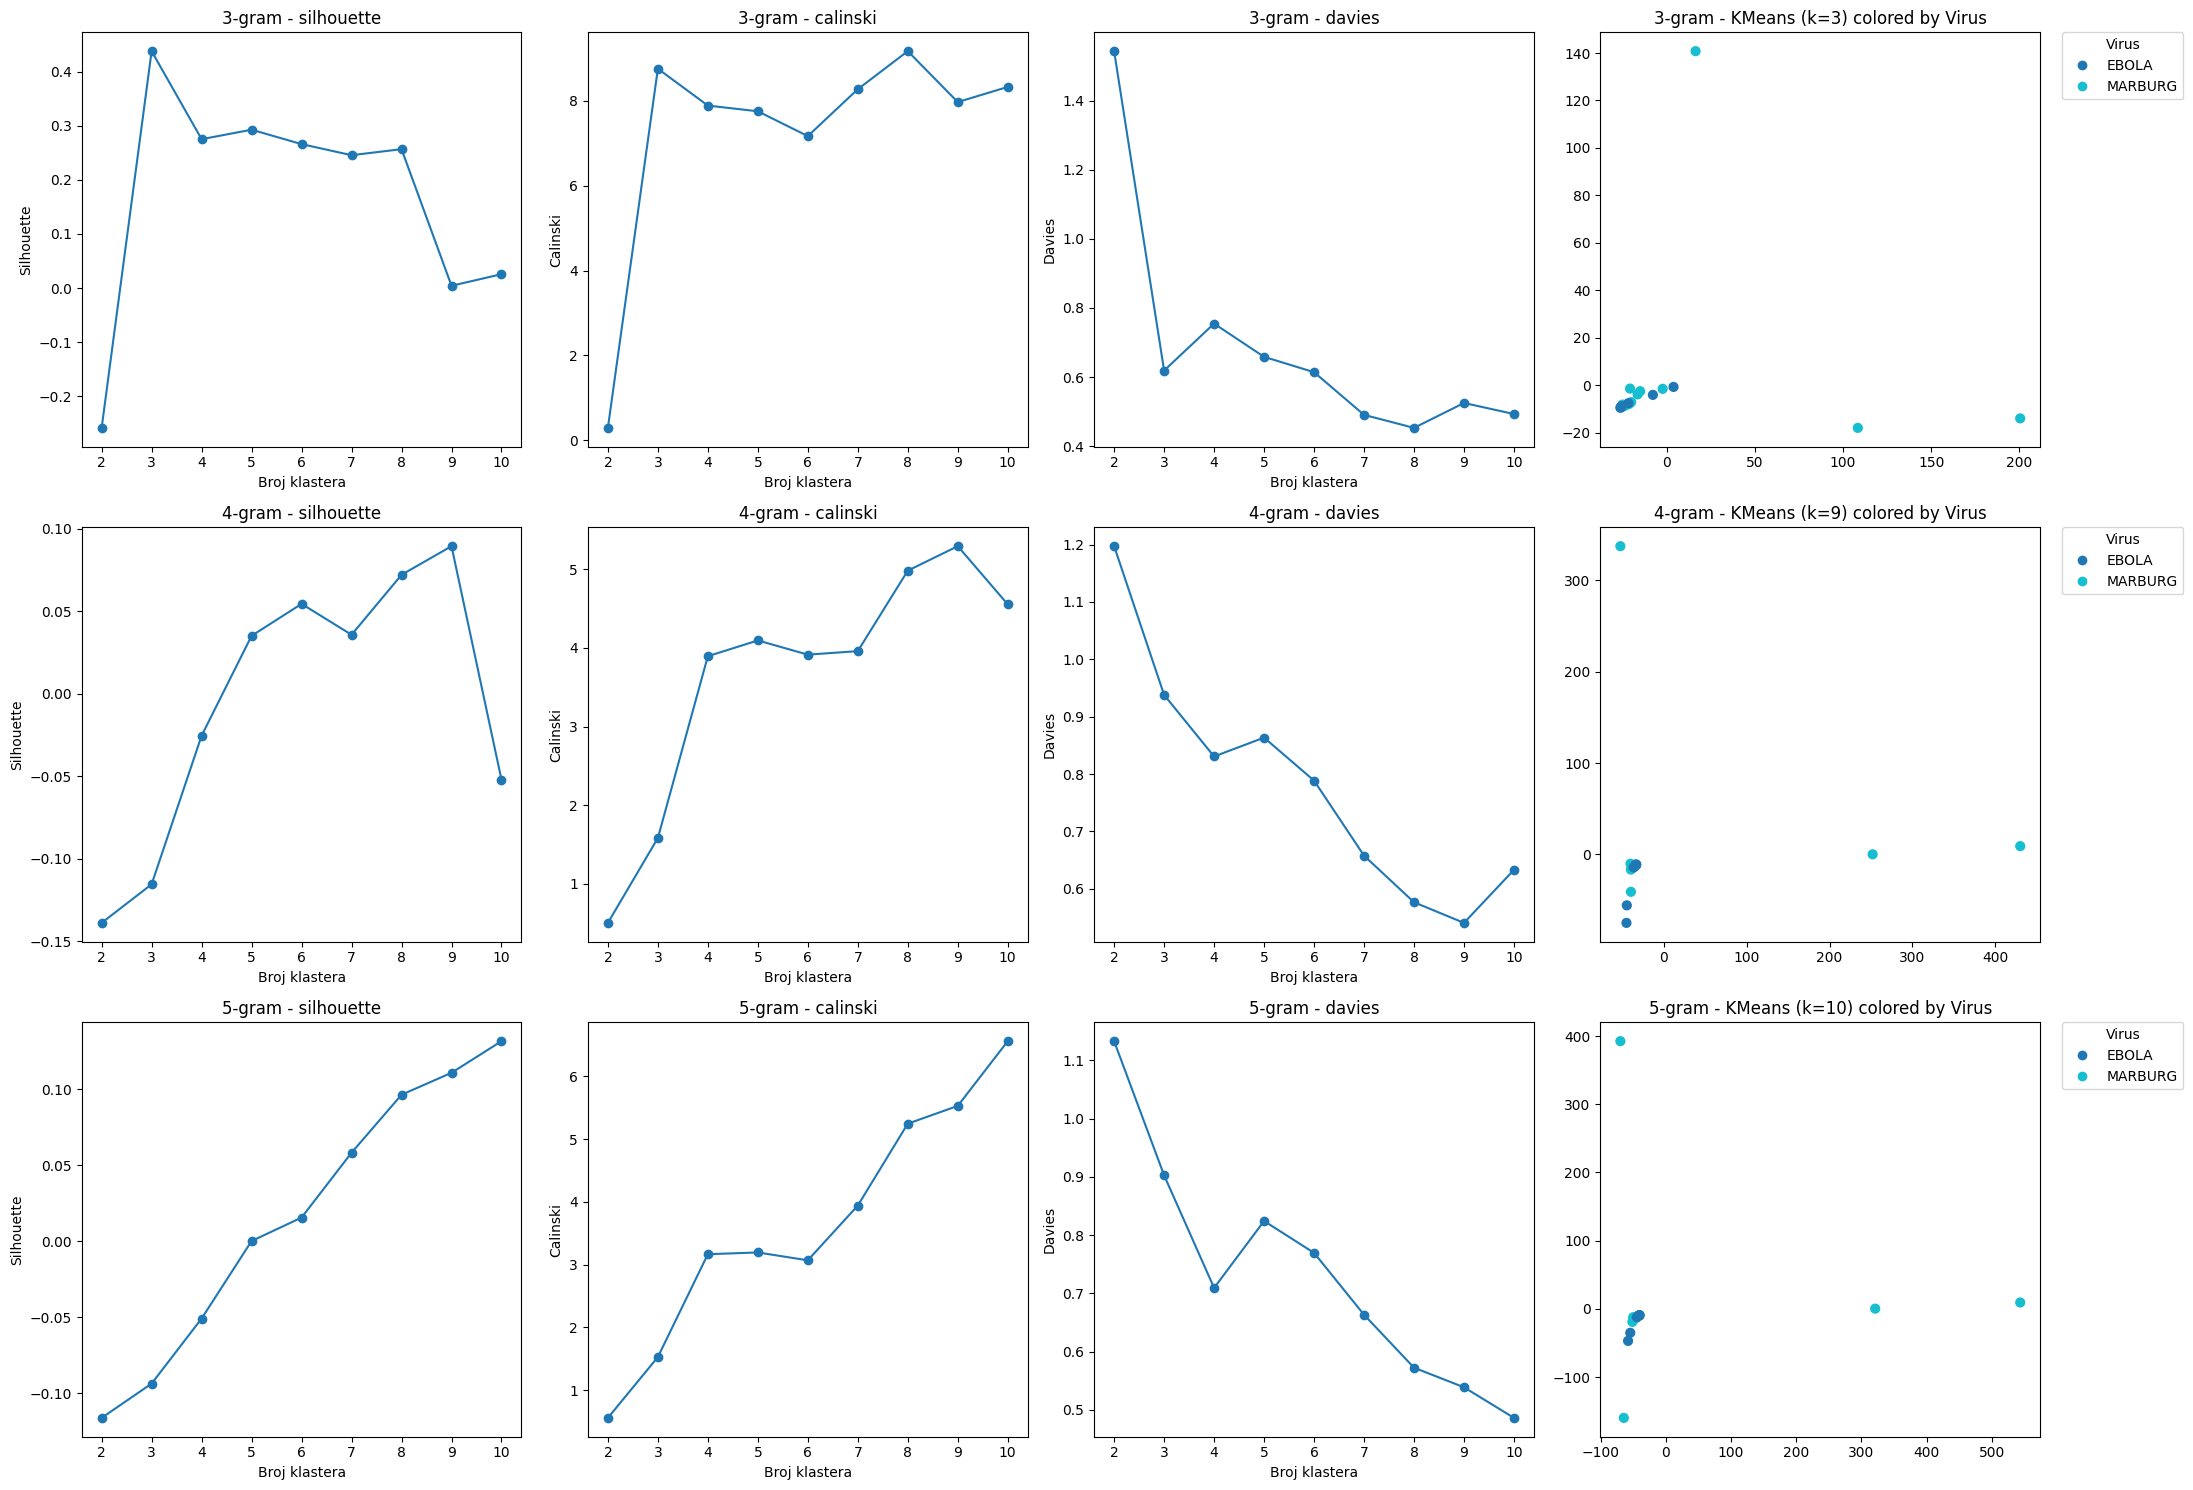

{'3-gram': {'clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'silhouette': [-0.2581594989077255,
   0.43770450990464543,
   0.2751078770600477,
   0.29262290099131893,
   0.26602195186457567,
   0.24555562325502334,
   0.2566707896485301,
   0.004333206442920734,
   0.02574155324670724],
  'calinski': [0.2929571342232637,
   8.753406647075572,
   7.885947981355399,
   7.751337612510644,
   7.166369354692554,
   8.271677247738461,
   9.167516639370566,
   7.968734293018137,
   8.324728444647711],
  'davies': [1.5431514959286958,
   0.6189535955576551,
   0.7547771416847268,
   0.6586334258707549,
   0.6142967516759578,
   0.4907479806718336,
   0.45308587703864645,
   0.5251672800867986,
   0.49313177911590883]},
 '4-gram': {'clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'silhouette': [-0.13883427510397545,
   -0.11544715775408827,
   -0.025396542542048504,
   0.035108001796194395,
   0.05446201579483863,
   0.03574488372273461,
   0.07206205884511555,
   0.0894266960978779,
   -0.0521202285772

In [12]:
kmeans_clustering(datasets)

In [13]:
def visualize_clusters_only(datasets, label_key="virus_type", k=2):
    """
    Vizuelizacija KMeans klastera u 2D prostoru (PCA),
    obojenih po virusima/proteinima.
    """

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(7 * n_plots, 6))

    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        labels = df[label_key].astype(str).values

        # Uzmi samo numeričke kolone
        numeric_data = df.select_dtypes(include=[np.number]).values

        # Skaliranje
        scaler = StandardScaler()
        numeric_scaled = scaler.fit_transform(numeric_data)

        # PCA za vizuelizaciju
        pca = PCA(n_components=2, random_state=42)
        reduced_data = pca.fit_transform(numeric_scaled)

        # KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        clusters = kmeans.fit_predict(numeric_scaled)
        centers_2d = pca.transform(kmeans.cluster_centers_)

        # Boje po labeli (virus_type, protein_type...)
        unique_labels = sorted(set(labels))
        label_to_int = {lab: idx for idx, lab in enumerate(unique_labels)}
        color_vals = np.array([label_to_int[lab] for lab in labels])

        scatter = ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1],
            c=color_vals, cmap="tab10",
            s=80, edgecolor="k"
        )

        # Klaster centri kao crni X
        ax.scatter(
            centers_2d[:, 0], centers_2d[:, 1],
            marker="x", c="black", s=150, linewidths=3, label="Cluster centroid"
        )

        ax.set_title(f"{label} – klasteri i '{label_key}'", fontsize=14)
        ax.set_xlabel("PCA 1", fontsize=12)
        ax.set_ylabel("PCA 2", fontsize=12)
        ax.set_aspect("equal")

        # Dodaj legendu sa virusima/proteinima
        ncols = 1
        if len(unique_labels) > 10:
            ncols = 2
        if len(unique_labels) > 20:
            ncols = 3

        ax.legend(handles=scatter.legend_elements()[0],
                  labels=unique_labels,
                  title=label_key,
                  bbox_to_anchor=(1.05, 1), loc="upper left",
                  borderaxespad=0.,
                  ncol=ncols)

    plt.tight_layout()
    plt.show()

In [20]:
def draw_legend_for_labels(datasets, label_key="virus_type"):
    # Skupi sve vrednosti labela iz dataset-a koji imaju tu kolonu
    all_labels = pd.concat([
        df[label_key].astype(str).dropna()
        for df in datasets.values() if label_key in df.columns
    ])

    unique_labels = pd.Series(all_labels.unique())
    num_labels = len(unique_labels)

    # Umesto deprecated plt.cm.get_cmap
    cmap = colormaps.get_cmap("tab20").resampled(num_labels)
    colors = cmap(np.arange(num_labels))

    # Dimenzije legende
    ncol = 4
    n_rows = int(np.ceil(num_labels / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    # Rukuje boje i imena
    handles = [mpatches.Patch(color=colors[i], label=unique_labels[i]) for i in range(num_labels)]
    ax.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.0),
        fontsize=10,
        ncol=ncol,
        frameon=False
    )

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()

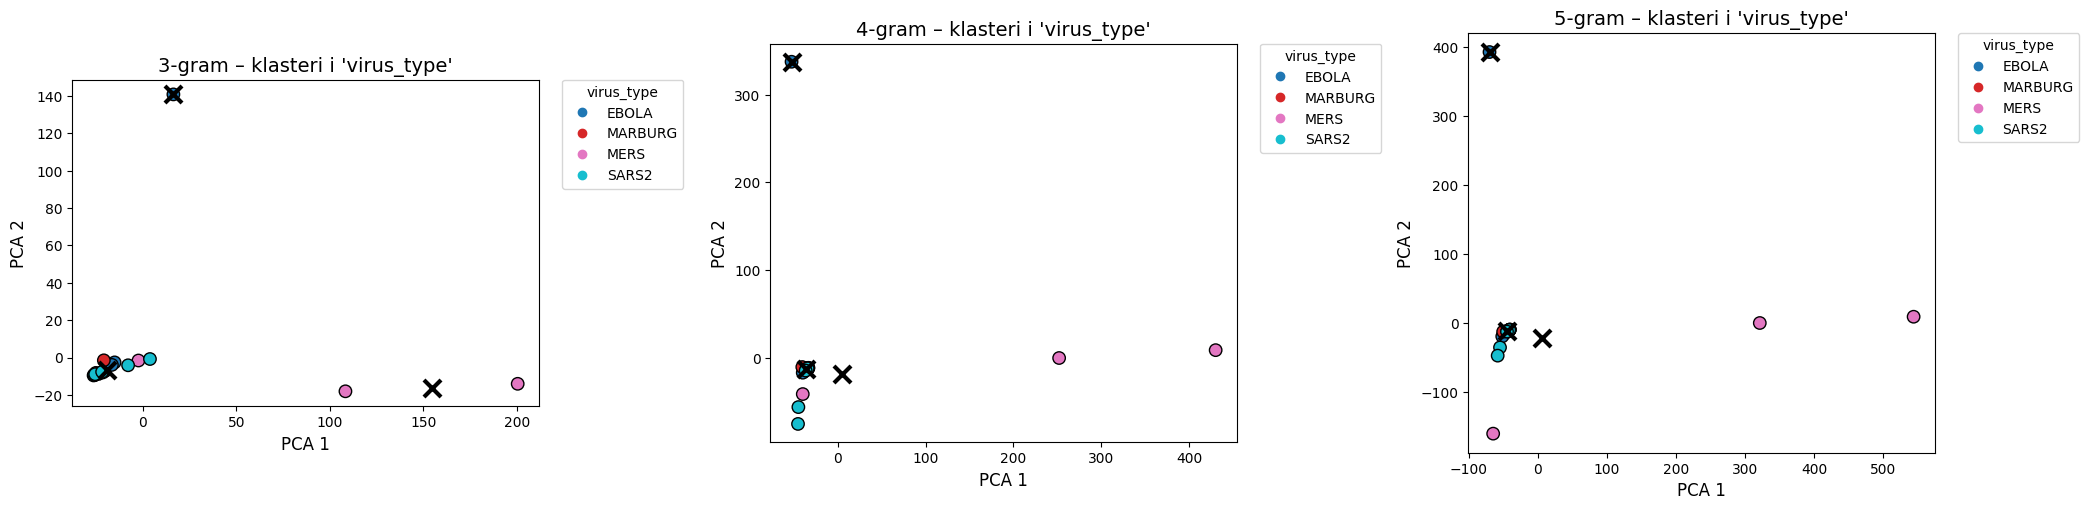

In [15]:
visualize_clusters_only(datasets, label_key="virus_type", k=3)

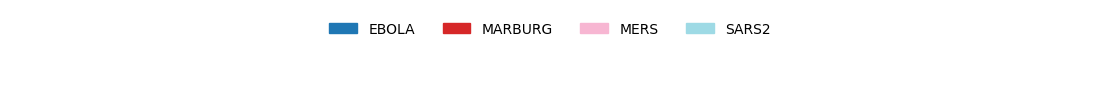

In [23]:
draw_legend_for_labels(datasets, label_key="virus_type")

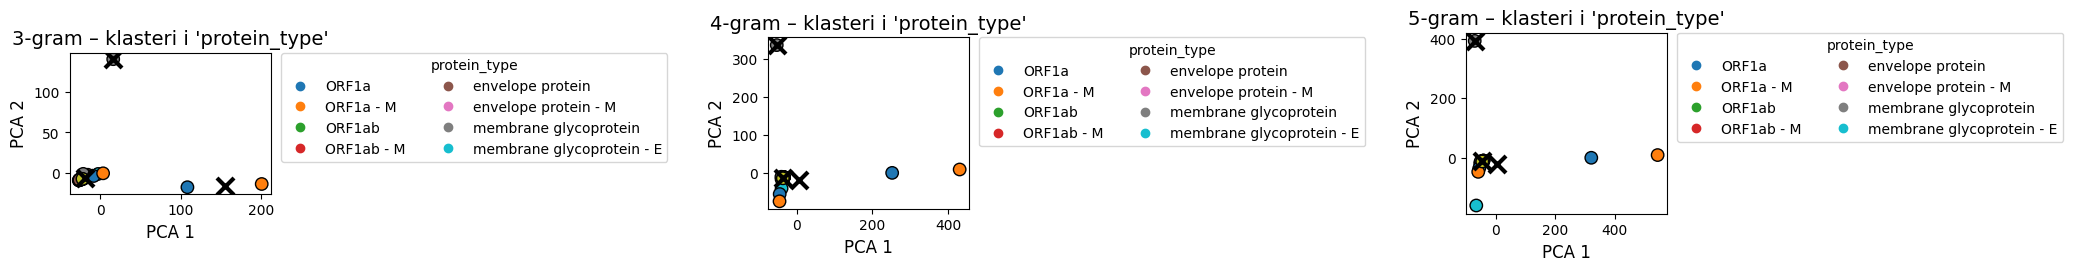

In [17]:
visualize_clusters_only(datasets, label_key="protein_type", k=3)

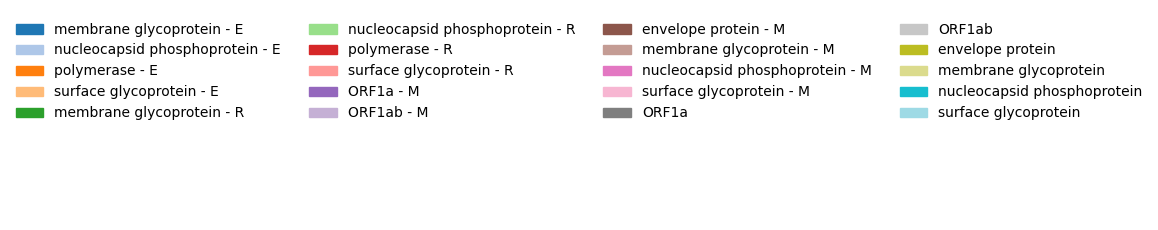

In [24]:
draw_legend_for_labels(datasets, label_key="protein_type")

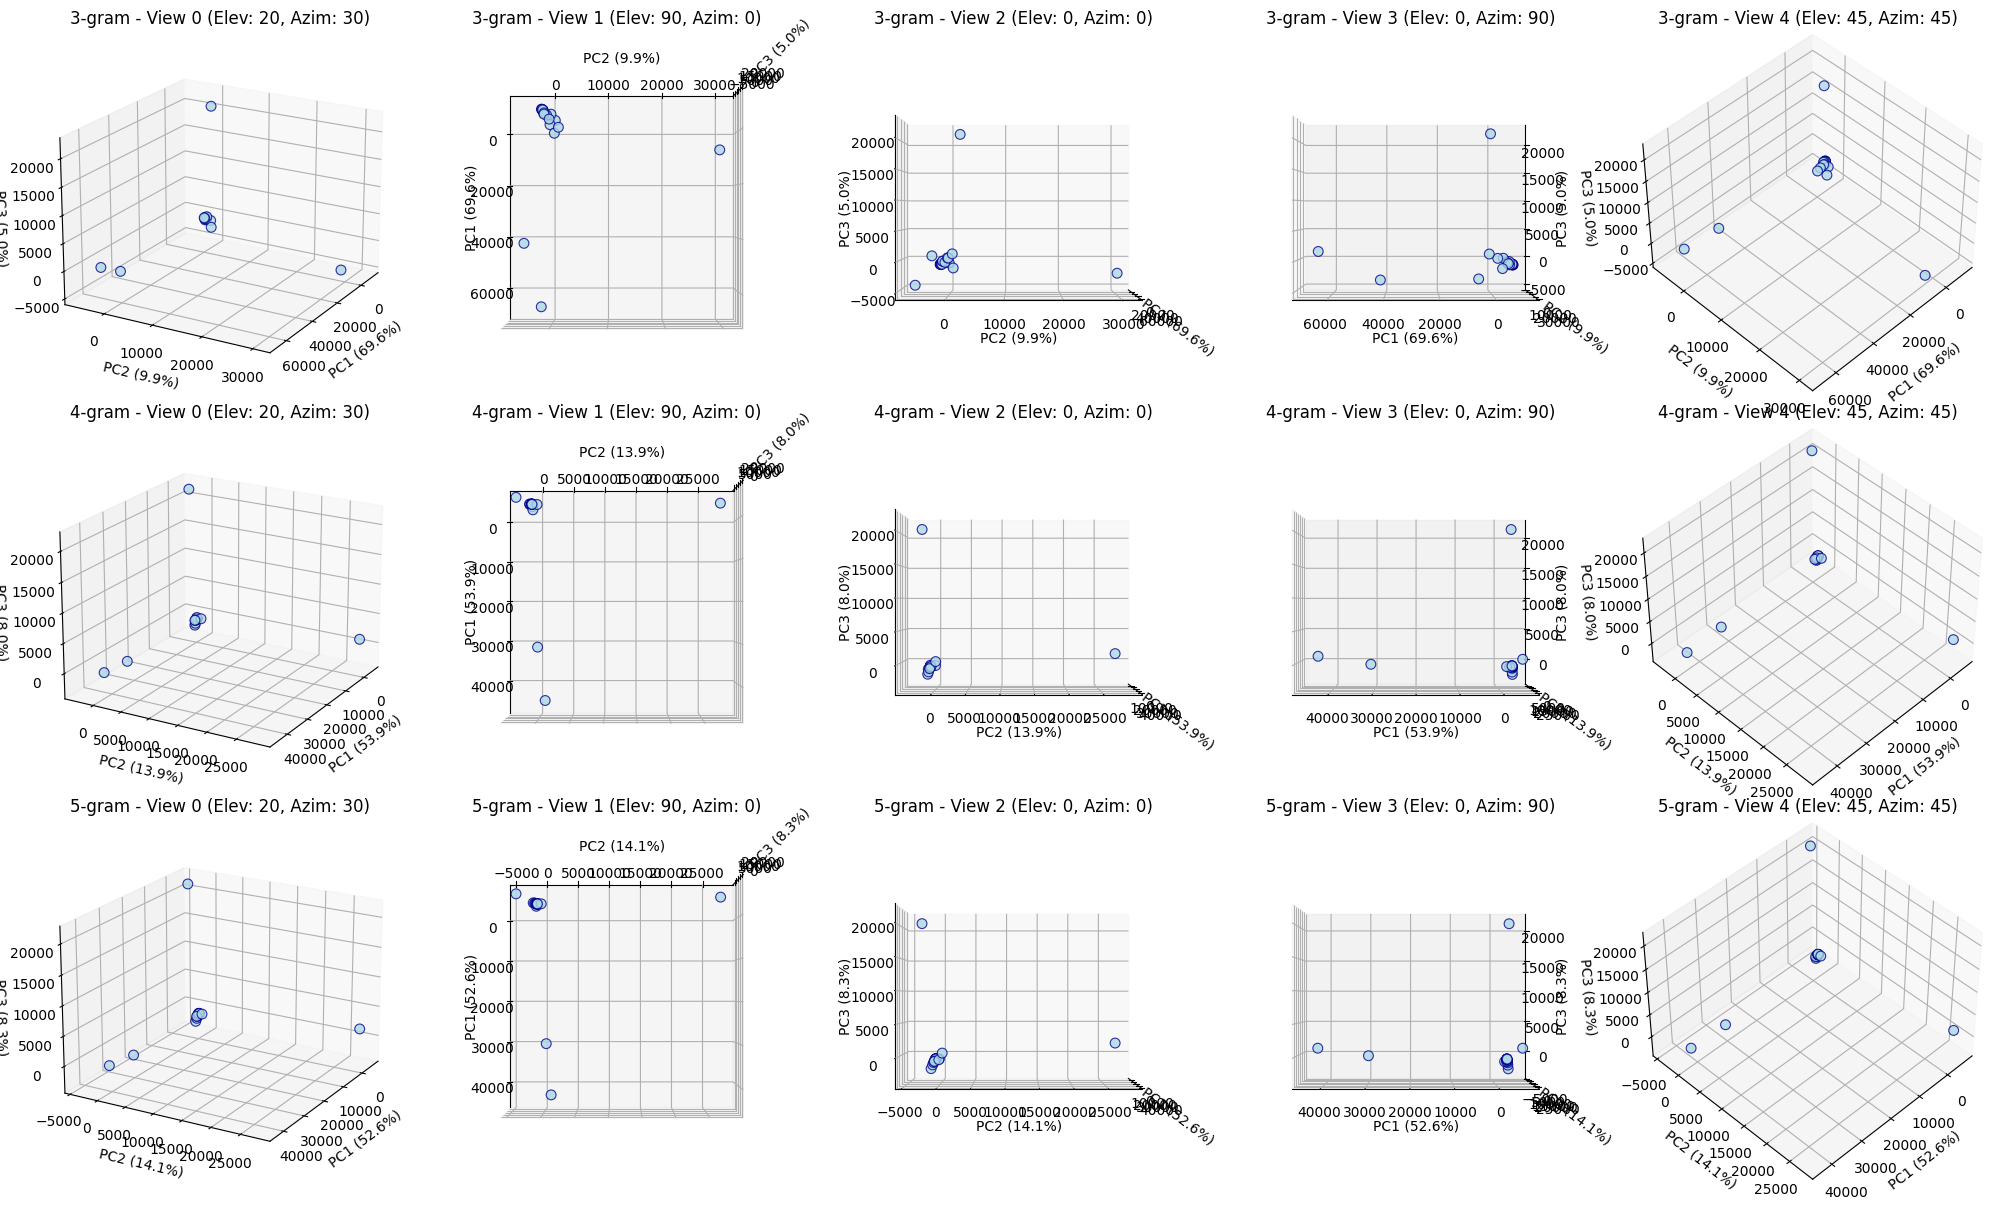

In [25]:
# Kreiraj figure i ose sa 3 reda i 5 kolona sa 3D projekcijom
fig, axes = plt.subplots(nrows=3, ncols=5, subplot_kw={"projection": "3d"}, figsize=(20, 12))

# Definiši različite poglede
viewpoints = [
    (20, 30),   # Default view
    (90, 0),    # Top-down view
    (0, 0),     # Front view
    (0, 90),    # Side view
    (45, 45)    # Isometric view
]

for i, (label, data) in enumerate(datasets.items()):
    numeric_data = data.select_dtypes(include=['number'])
    
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(numeric_data)
    explained_variance = pca.explained_variance_ratio_
    
    pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])
    
    for j, (elev, azim) in enumerate(viewpoints):
        ax = axes[i, j]
        ax.scatter(
            pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
            c='lightblue', edgecolors='darkblue', linewidth=0.8, alpha=0.8, s=50
        )
        
        ax.view_init(elev=elev, azim=azim)
        
        ax.set_title(f'{label} - View {j} (Elev: {elev}, Azim: {azim})')
        ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
        ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.1f}%)')

plt.tight_layout()
plt.show()

#  Hierarchical Clustering

In [26]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

In [27]:
def hierarchical_clustering(datasets):
    """
    Hierarchical (agglomerative) clustering evaluation.
    Radi na pivotiranim CSV-ovima (n-gram features u kolonama).
    Računa silhouette, calinski, davies za različite brojeve klastera.
    """
    cluster_range = range(2, 11)
    results = {ngram: {"clusters": [], "silhouette": [], "calinski": [], "davies": []} 
               for ngram in datasets}

    # Grid search po broju klastera
    for ngram, data in datasets.items():
        # uzimamo samo numeričke kolone
        data_numeric = data.select_dtypes(include=['number'])

        for k in cluster_range:
            model = AgglomerativeClustering(n_clusters=k)
            labels = model.fit_predict(data_numeric)

            results[ngram]["clusters"].append(k)
            results[ngram]["silhouette"].append(silhouette_score(data_numeric, labels))
            results[ngram]["calinski"].append(calinski_harabasz_score(data_numeric, labels))
            results[ngram]["davies"].append(davies_bouldin_score(data_numeric, labels))

    # Plot metric scores for each n-gram
    fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 4 * len(datasets)))
    if len(datasets) == 1:
        axes = [axes]

    metrics = ["silhouette", "calinski", "davies"]

    for i, (ngram, scores) in enumerate(results.items()):
        for j, metric in enumerate(metrics):
            ax = axes[i][j] if len(datasets) > 1 else axes[j]
            ax.plot(scores["clusters"], scores[metric], marker='o')
            ax.set_title(f"{ngram} - {metric}")
            ax.set_xlabel("Broj klastera")
            ax.set_ylabel(metric.capitalize())

    plt.tight_layout()
    plt.show()
    return results

In [28]:
df3 = load_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = load_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = load_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

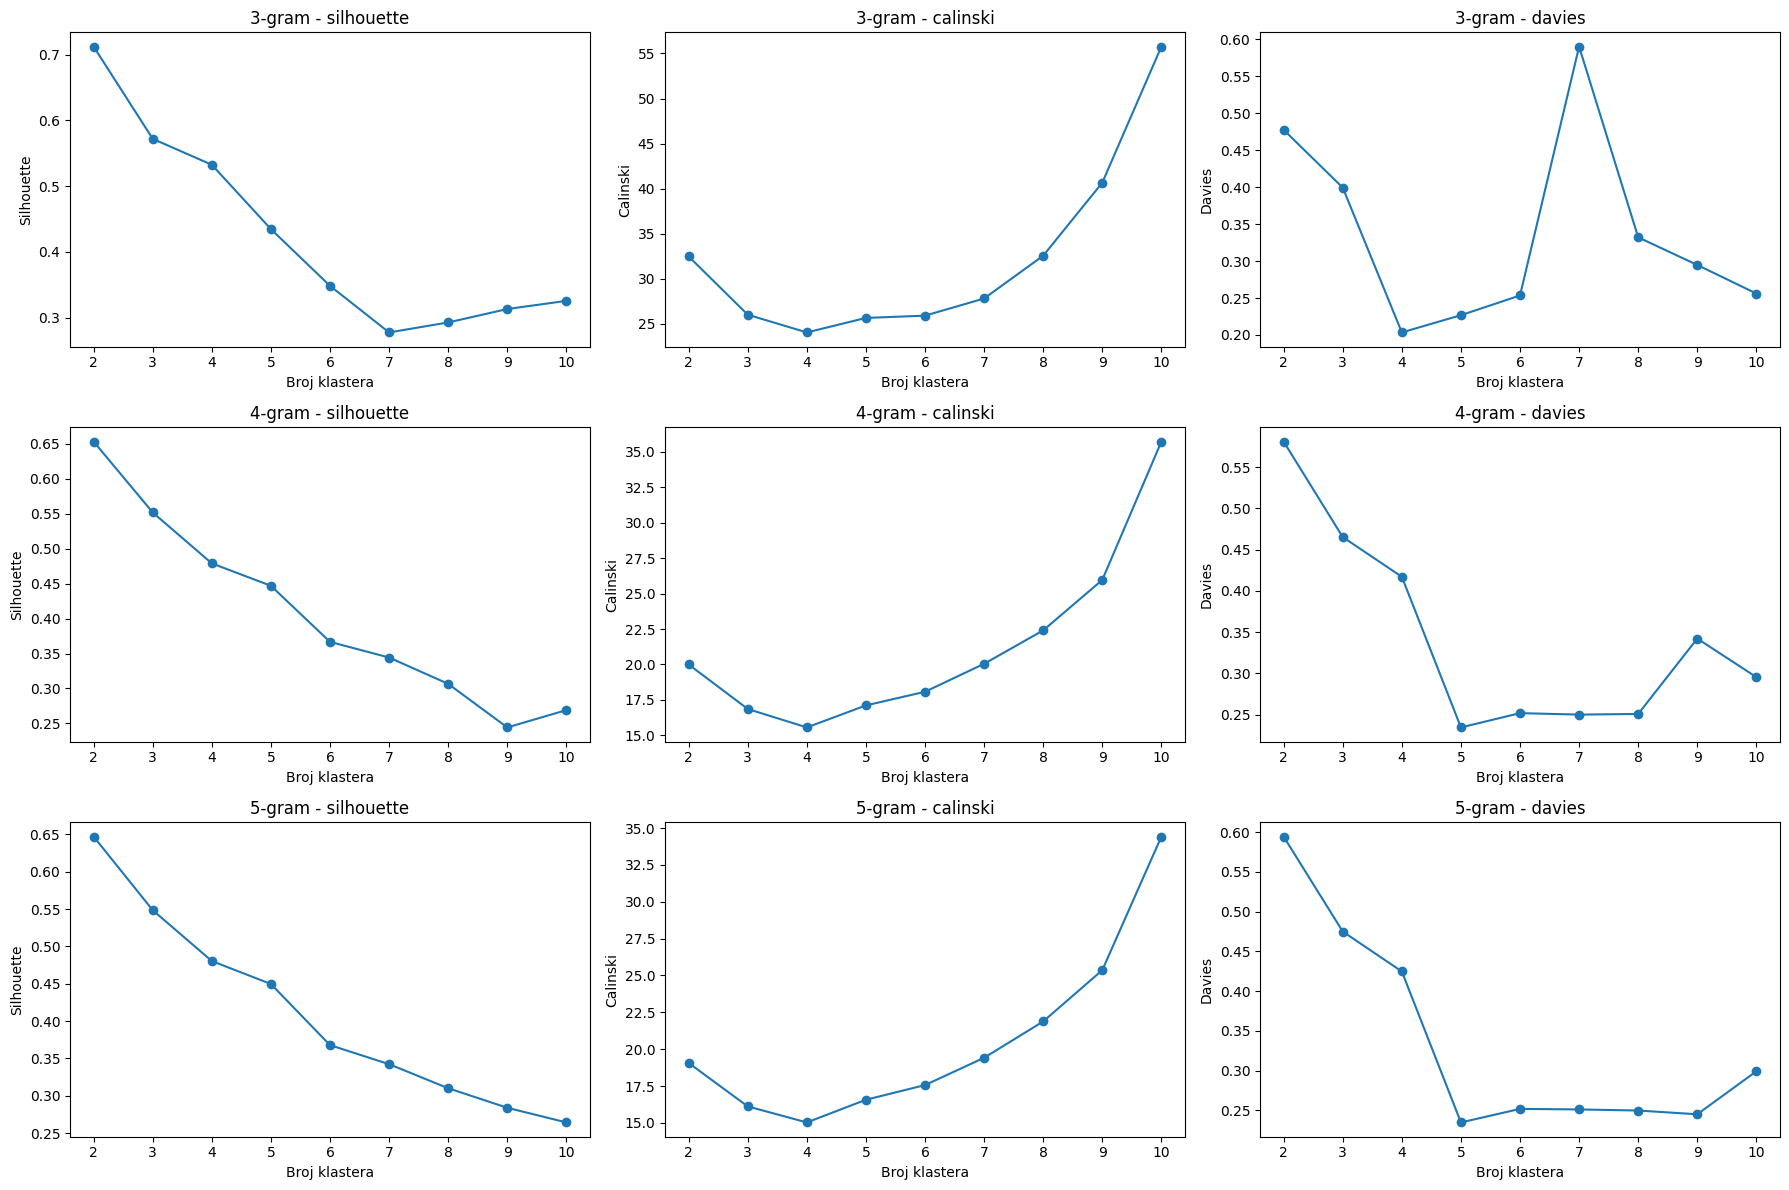

{'3-gram': {'clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'silhouette': [0.7121929762719369,
   0.5718629647097304,
   0.5323978792842345,
   0.4345423507867417,
   0.3481624958391485,
   0.27734023976415223,
   0.29251819069207835,
   0.3129468717667335,
   0.32537572138672133],
  'calinski': [32.48741204126408,
   26.024591515445238,
   24.060074850757694,
   25.66892158115421,
   25.920901673418506,
   27.824757988487953,
   32.56750571649399,
   40.6674775940576,
   55.76094030295867],
  'davies': [0.47735050711157,
   0.3991713304640914,
   0.20347148131963275,
   0.22678488496280247,
   0.25340986156471074,
   0.5898269449521895,
   0.33204355034436994,
   0.2946614407548495,
   0.25605122216013154]},
 '4-gram': {'clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'silhouette': [0.6532102097759462,
   0.5517988444282997,
   0.47895691720761313,
   0.4468871336364463,
   0.36664722076789336,
   0.3442372184030918,
   0.3065742391317544,
   0.2442030373305303,
   0.2689887668226071],
  'cali

In [29]:
hierarchical_clustering(datasets)

In [36]:
def get_color_map_for_labels(datasets, label_key="virus_type"):
    """
    Generiše mapu labela u boje na osnovu zadatog label_key (npr. virus_type, protein_type).
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Skupi sve labele iz svih dataset-a
    all_labels = pd.concat([df[label_key].astype(str) for df in datasets.values()])
    unique_labels = sorted(all_labels.unique())
    num_labels = len(unique_labels)

    # Colormap
    cmap = plt.get_cmap("tab20")  # bez drugog argumenta

    # Mapiranje labela na boje (normalizacija indeksa)
    color_map = {label: cmap(i / num_labels) for i, label in enumerate(unique_labels)}

    return color_map

In [37]:
def visualize_clusters_only(datasets, label_key="virus_type", k=2):
    """
    Vizuelizuje klastere koristeći PCA smanjenje na 2D.
    Boji tačke po zadatom label_key (virus_type ili protein_type).
    Klasteri su prikazani sa crnim X markerima.
    """
    color_map = get_color_map_for_labels(datasets, label_key)

    n_plots = len(datasets)
    fig, axs = plt.subplots(1, n_plots, figsize=(18, 5))
    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        labels = df[label_key].astype(str)
        numeric_data = df.select_dtypes(include=[np.number])

        # PCA redukcija na 2D
        pca = PCA(n_components=2, random_state=42)
        reduced_data = pca.fit_transform(numeric_data.values)

        # Hijerarhijsko klasterovanje
        model = AgglomerativeClustering(n_clusters=k)
        clusters = model.fit_predict(numeric_data.values)

        # Računanje centara klastera u PCA prostoru
        centers = []
        for cluster_id in range(k):
            points_in_cluster = reduced_data[clusters == cluster_id]
            center = points_in_cluster.mean(axis=0)
            centers.append(center)
        centers_2d = np.array(centers)

        # Boje po labelama
        colors = labels.map(color_map)

        # Scatter plot tačaka
        ax.scatter(
            reduced_data[:, 0], reduced_data[:, 1],
            c=colors,
            s=80, edgecolor='k'
        )

        # Klaster centroidi
        ax.scatter(
            centers_2d[:, 0], centers_2d[:, 1],
            marker='x', c='black', s=150, linewidths=3, label='Cluster centroid'
        )

        # Naslovi i ose
        ax.set_title(f"{label} – klasteri i '{label_key}'", fontsize=14)
        ax.set_xlabel("PCA 1", fontsize=12)
        ax.set_ylabel("PCA 2", fontsize=12)
        ax.set_aspect('equal')

        # Legenda za klase (virus/protein)
        handles = [
            mpatches.Patch(color=color_map[lbl], label=lbl)
            for lbl in sorted(labels.unique())
        ]
        ax.legend(handles=handles, title=label_key, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [32]:
def draw_legend_for_labels(datasets, label_key="virus_type"):
    """
    Iscrtava legendu za sve jedinstvene labele iz datasets (virus_type ili protein_type),
    koristeći boje iz get_color_map_for_labels.
    """
    color_map = get_color_map_for_labels(datasets, label_key)
    unique_labels = sorted(color_map.keys())  # sortirano da bude preglednije
    colors = [color_map[lbl] for lbl in unique_labels]

    # Automatski broj redova na osnovu broja labela
    ncol = 4
    n_rows = int(np.ceil(len(unique_labels) / ncol))
    fig_height = 0.6 + n_rows * 0.3

    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis("off")

    handles = [
        mpatches.Patch(color=colors[i], label=unique_labels[i])
        for i in range(len(unique_labels))
    ]

    ax.legend(
        handles=handles,
        title=label_key,  # Dodato da se zna da li je virus/protein
        loc="upper center",
        bbox_to_anchor=(0.5, 1.0),
        fontsize=10,
        ncol=ncol,
        frameon=False
    )

    plt.subplots_adjust(top=1, bottom=0, left=0.05, right=0.95)
    plt.show()

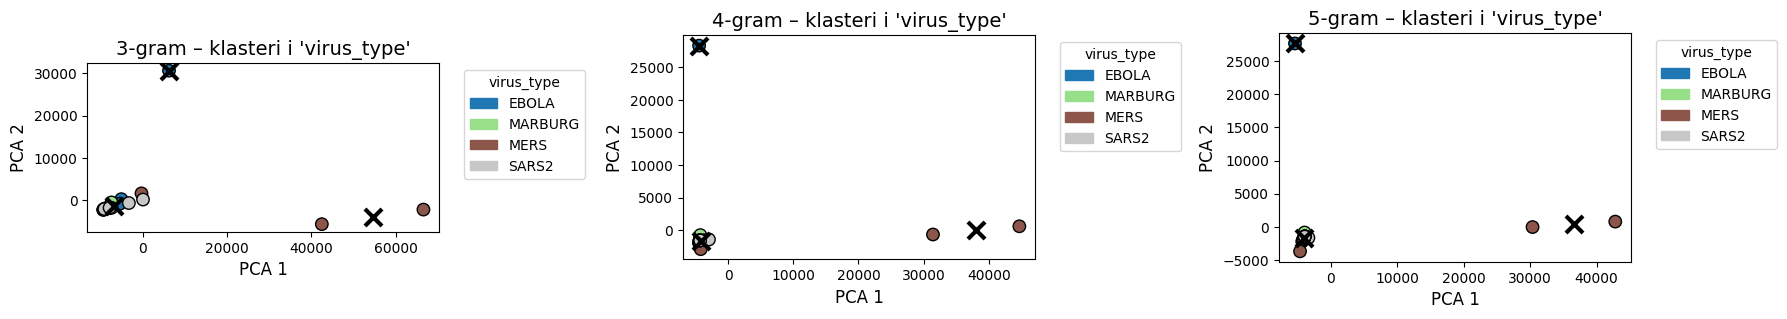

In [38]:
visualize_clusters_only(datasets, label_key="virus_type", k=3)

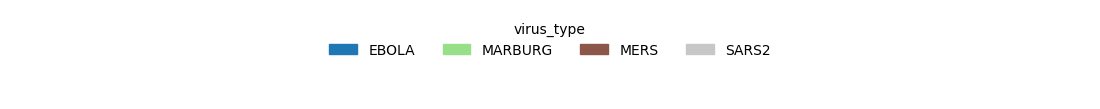

In [39]:
draw_legend_for_labels(datasets, label_key="virus_type")

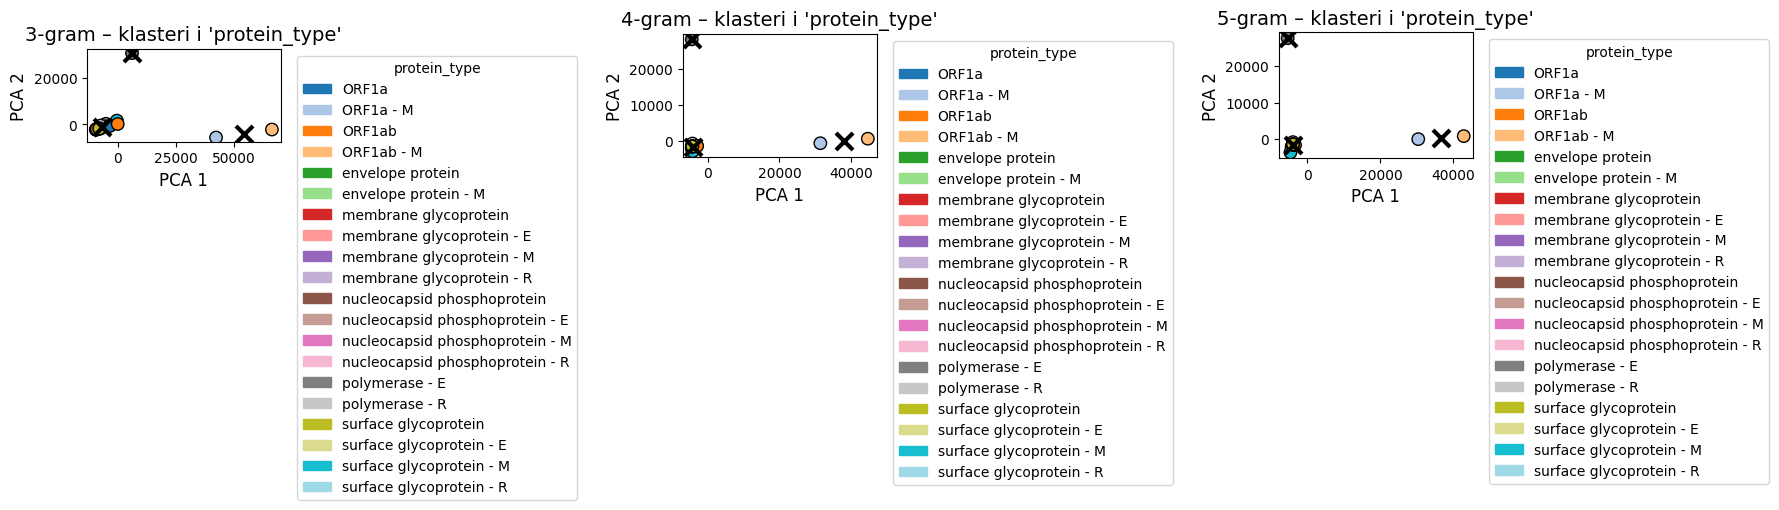

In [40]:
visualize_clusters_only(datasets, label_key="protein_type", k=3)

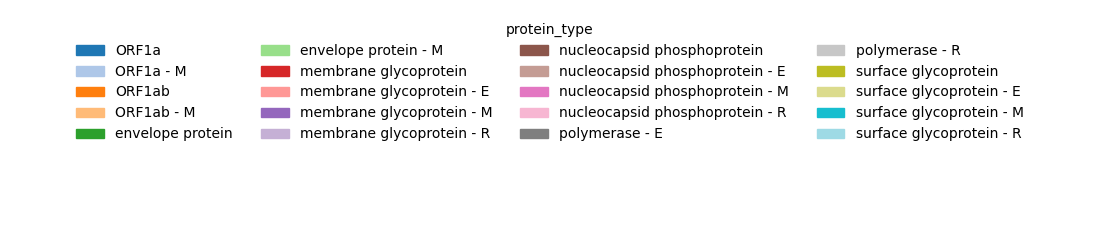

In [41]:
draw_legend_for_labels(datasets, label_key="protein_type")

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

def plot_dendrograms_simplified(datasets):
    n_plots = len(datasets)
    fig, axs = plt.subplots(n_plots, 1, figsize=(20, 5 * n_plots))  # više širine
    if n_plots == 1:
        axs = [axs]

    for ax, (label, df) in zip(axs, datasets.items()):
        data_numeric = df.iloc[:, 2:].values

        Z = linkage(data_numeric, method='ward')

        dendrogram(
            Z,
            ax=ax,
            truncate_mode='level', 
            p=6,                     
            labels=None,            
            leaf_rotation=90,
            leaf_font_size=6,
            show_contracted=True,
            show_leaf_counts=True,     
            distance_sort='descending' 
        )

        ax.set_title(f"Simplified Dendrogram - {label}", fontsize=14)
        ax.set_ylabel("Distance")

    plt.tight_layout()
    plt.show()

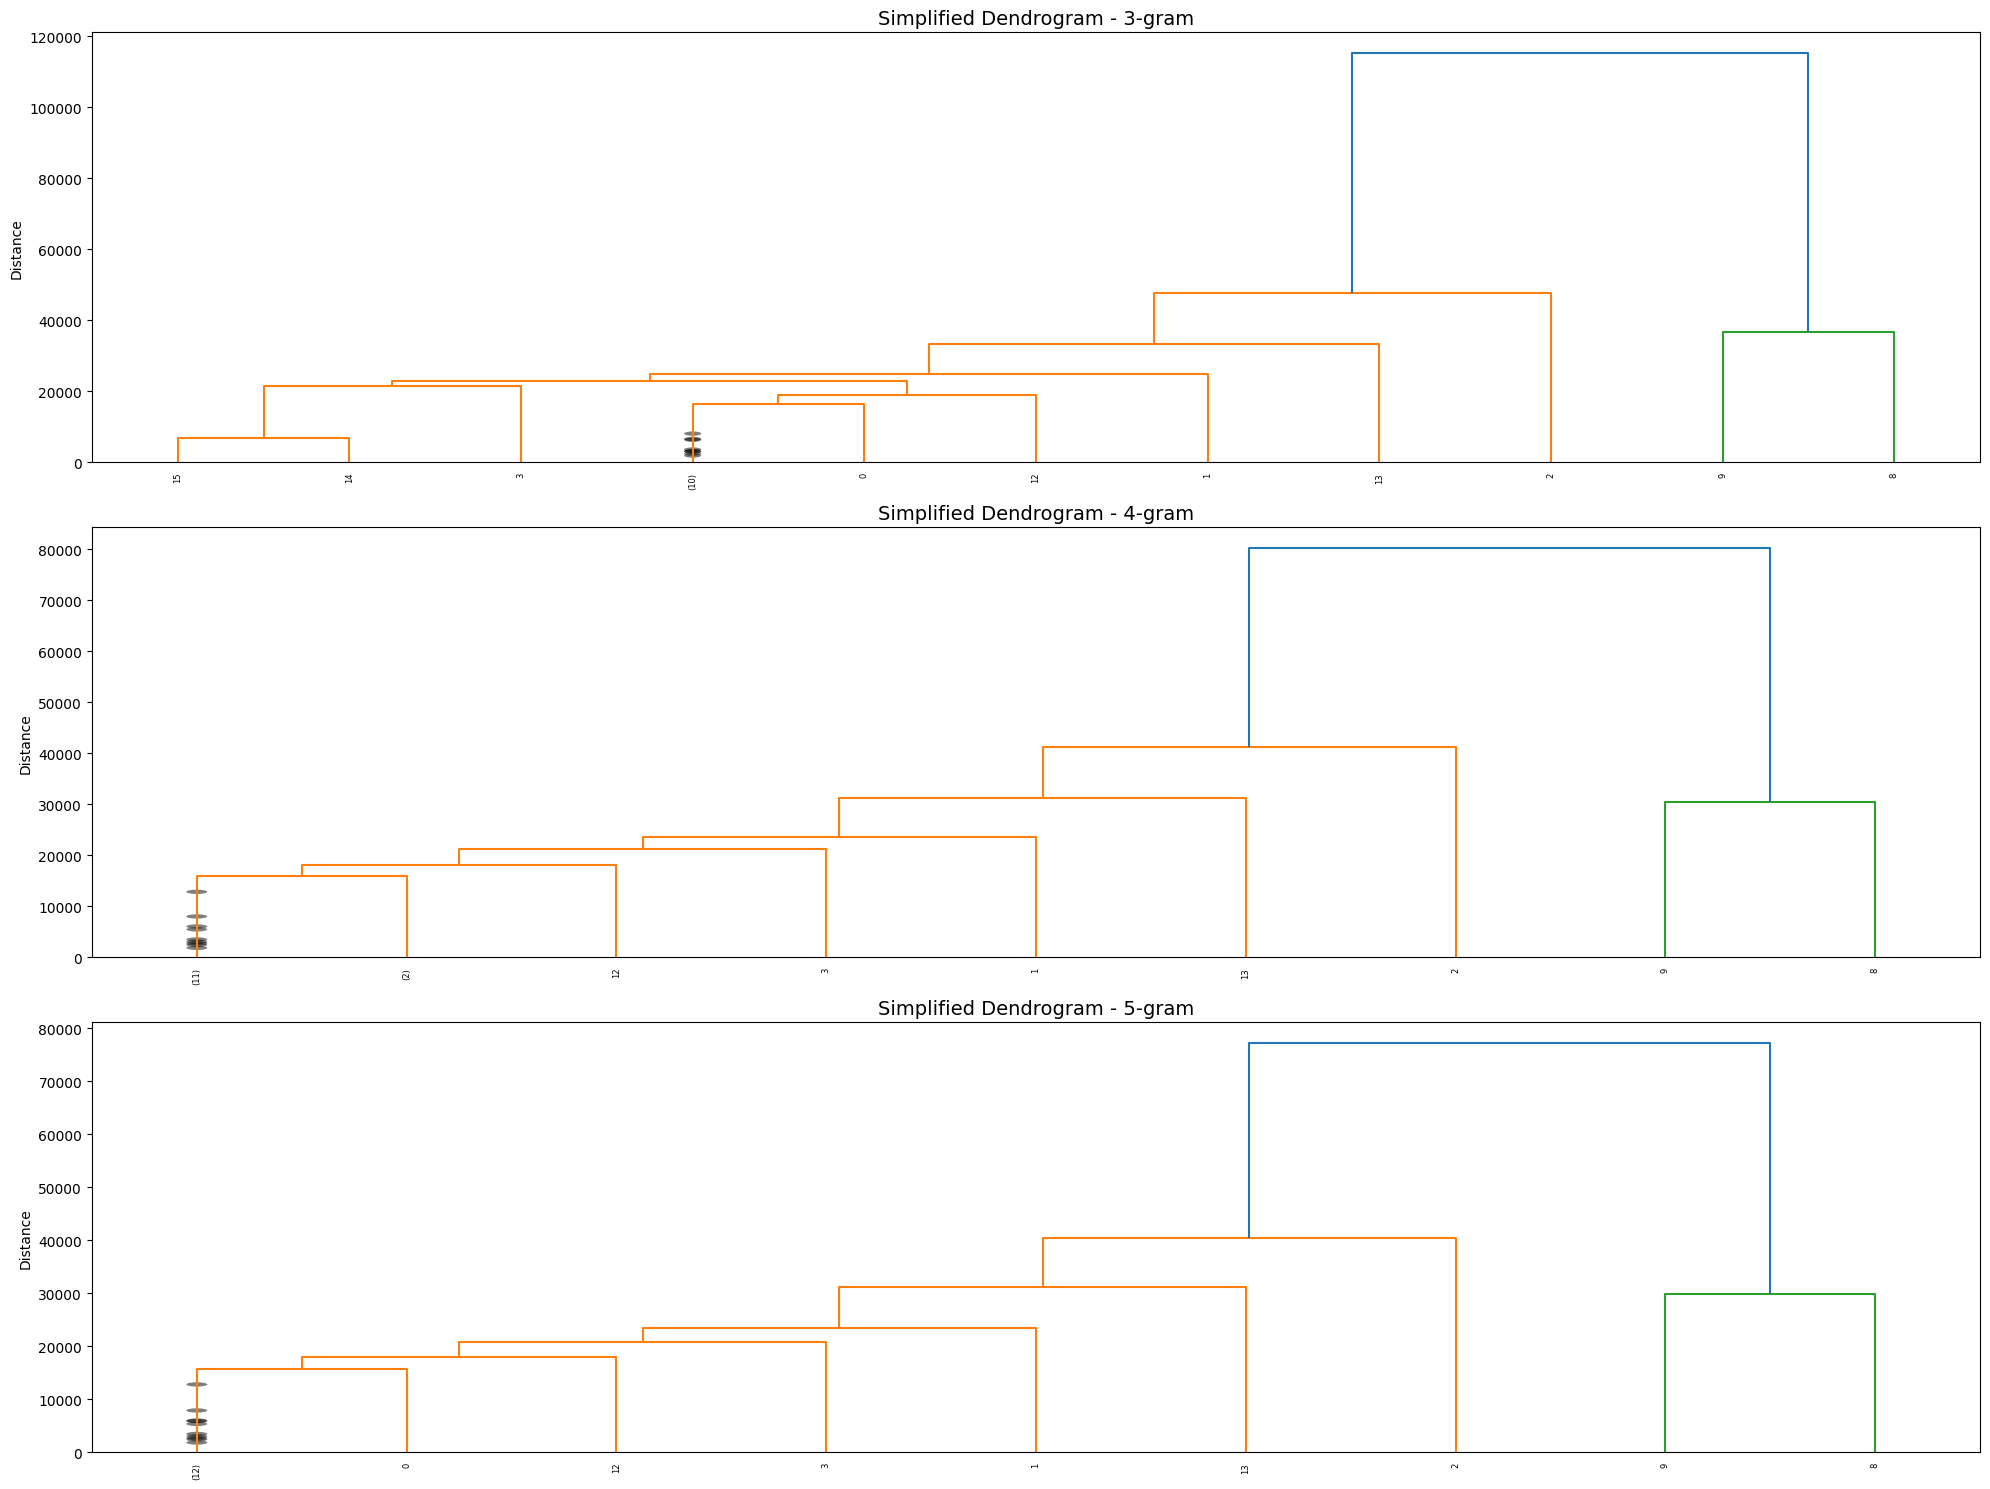

In [43]:
plot_dendrograms_simplified(datasets)

# SOM

In [1]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [23]:
def som(datasets, label_column='virus_type', som_x=15, som_y=15, iterations=1000):
    """
    Trains and visualizes SOMs on amino acid n-gram datasets
    where n-gram features su vertikalno u CSV-u (pivotirano loader-om).
    Bojenje po 'virus_type' ili 'protein_type'.
    """
    if isinstance(datasets, dict):
        items = list(datasets.items())
    else:
        items = [("dataset", datasets)]

    results = []
    fig, axes = plt.subplots(len(items), 2, figsize=(12, 5 * len(items)))
    if len(items) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (ngram_name, df) in enumerate(items):
        labels = df[label_column].astype(str).values

        # uzmi samo numeričke kolone kao feature-e
        features_df = df.select_dtypes(include=[np.number])
        features = features_df.values

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        som_obj = MiniSom(x=som_x, y=som_y, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
        som_obj.random_weights_init(features_scaled)
        som_obj.train_random(features_scaled, num_iteration=iterations)

        bmu_coords = np.array([som_obj.winner(x) for x in features_scaled])

        unique_labels = sorted(set(labels))
        label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
        color_labels = np.array([label_to_int[label] for label in labels])

        results.append({
            "n_gram": ngram_name,
            "n_clusters": len(np.unique(bmu_coords, axis=0))
        })

        # U-Matrix
        ax1 = axes[i, 0]
        ax1.set_title(f"SOM U-Matrix ({ngram_name})")
        im = ax1.pcolor(som_obj.distance_map().T, cmap='bone_r')
        fig.colorbar(im, ax=ax1)

        # Pozicije uzoraka obojene ext. labelom
        ax2 = axes[i, 1]
        ax2.set_title(f"SOM Colored by {label_column} ({ngram_name})")
        scatter = ax2.scatter(bmu_coords[:, 0], bmu_coords[:, 1], c=color_labels, cmap='tab10', s=40)
        ax2.set_xlim(0, som_x)
        ax2.set_ylim(0, som_y)
        ax2.legend(handles=scatter.legend_elements()[0], labels=unique_labels, title=label_column)

    plt.tight_layout()
    plt.show()
    return results


In [21]:
df3 = load_csv("../csv_data/3gram_matrix_amino_acid_combined.csv")
df4 = load_csv("../csv_data/4gram_matrix_amino_acid_combined.csv")
df5 = load_csv("../csv_data/5gram_matrix_amino_acid_combined.csv")
datasets = {"3-gram": df3, "4-gram": df4, "5-gram": df5}

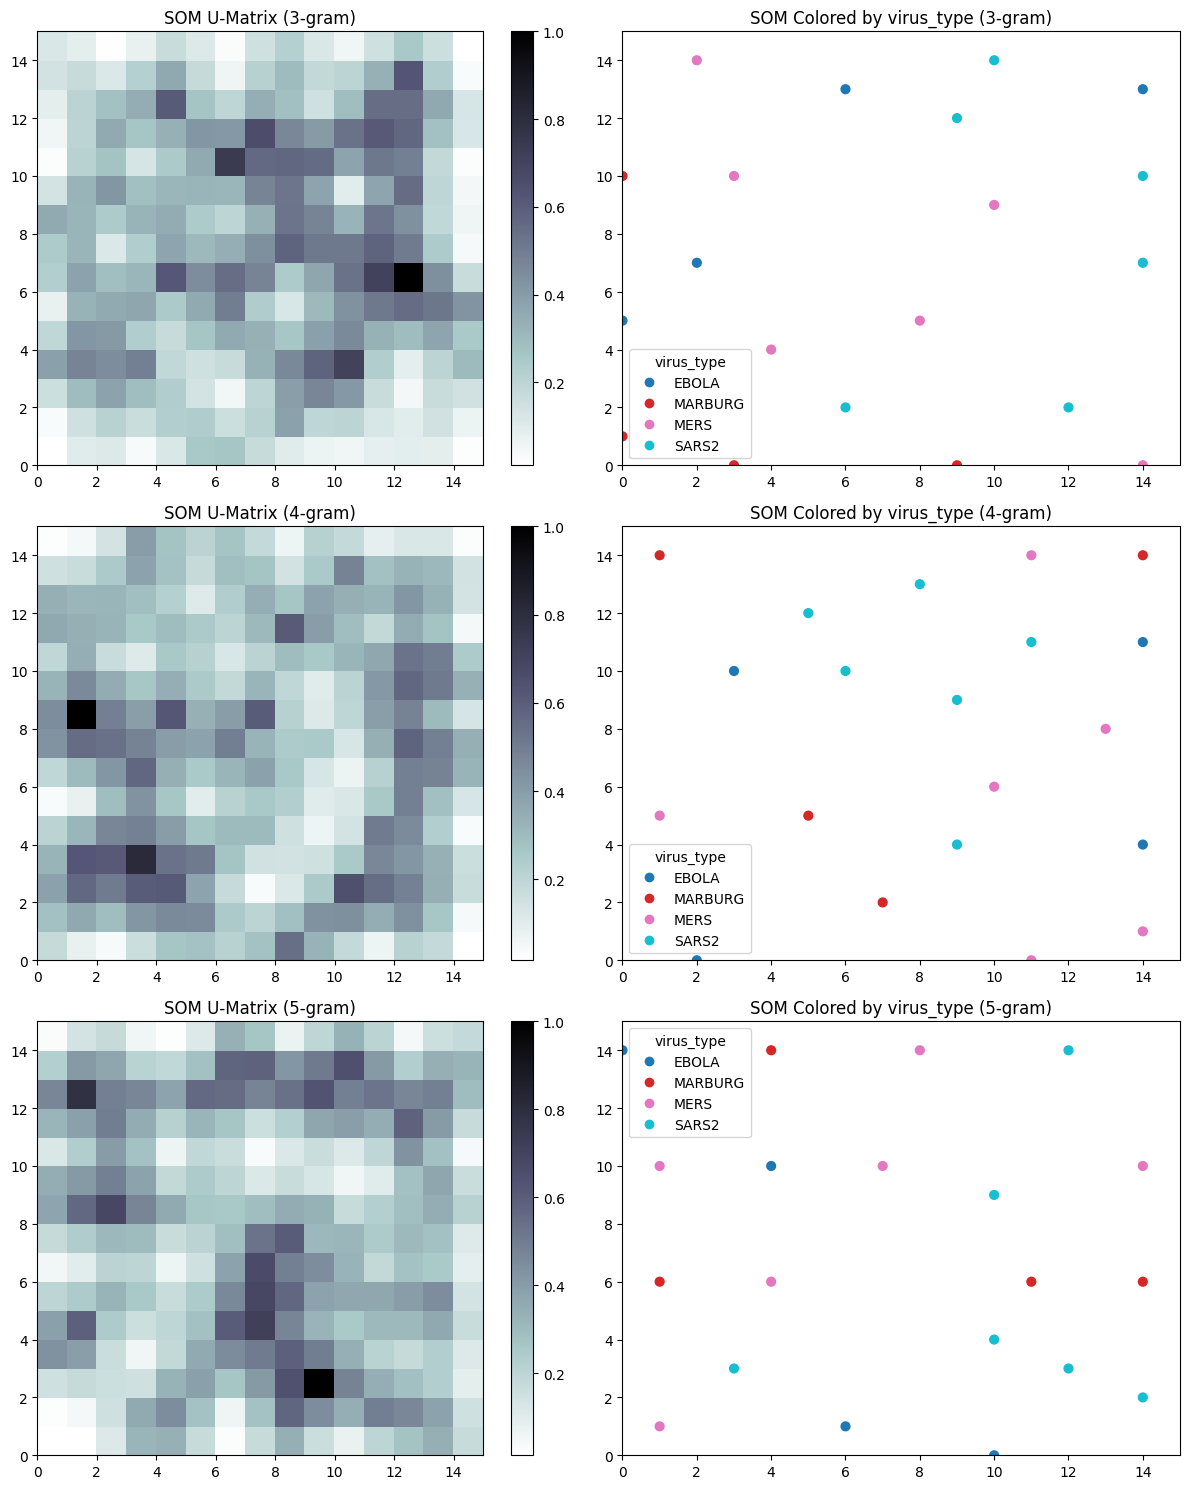

[{'n_gram': '3-gram', 'n_clusters': 20},
 {'n_gram': '4-gram', 'n_clusters': 20},
 {'n_gram': '5-gram', 'n_clusters': 20}]

In [24]:
som(datasets, label_column='virus_type')

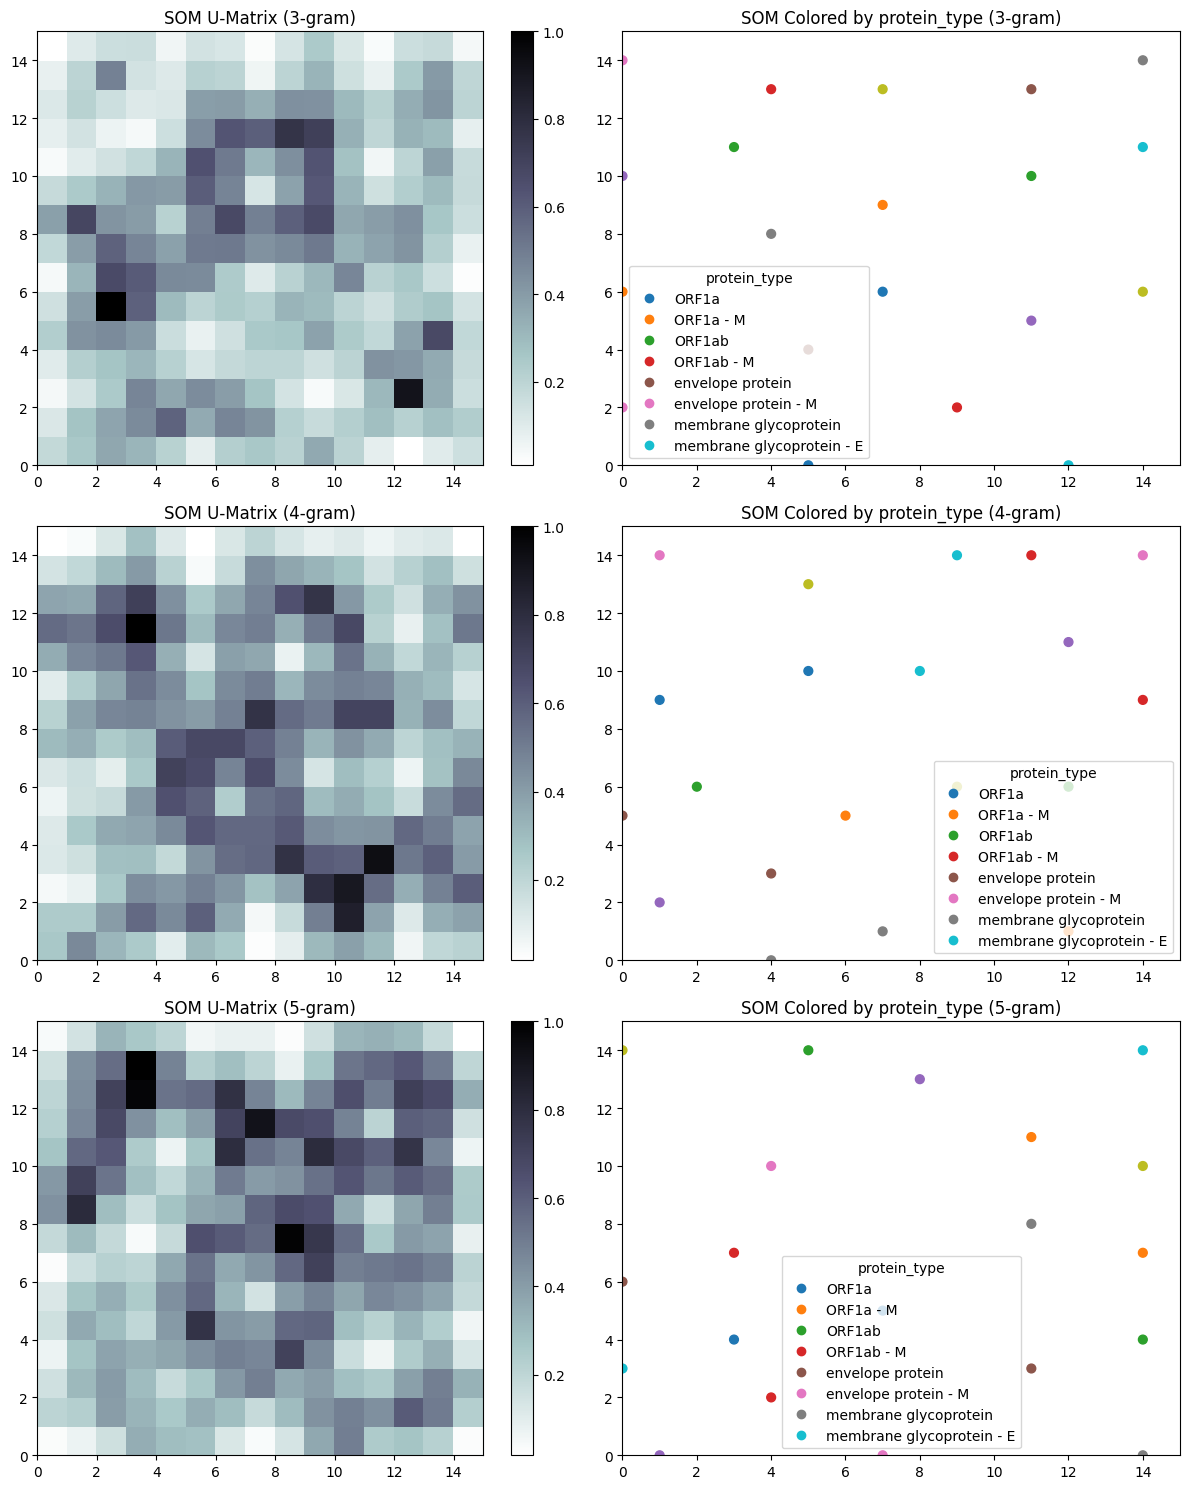

[{'n_gram': '3-gram', 'n_clusters': 20},
 {'n_gram': '4-gram', 'n_clusters': 20},
 {'n_gram': '5-gram', 'n_clusters': 20}]

In [25]:
som(datasets, label_column='protein_type')